In [ ]:
!pip install transformers torch

In [ ]:
!pip install transformers huggingface_hub


In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")


In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

In [ ]:
input_text = "फ्रांस की राजधानी क्या है?"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")

outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0]))

In [ ]:
! huggingface-cli login

In [ ]:
# Prepare input text
input_text = "फ्रांस की राजधानी क्या है?"
inputs = tokenizer(input_text, return_tensors="pt").to(device)
decoder_input_ids = torch.full((inputs['input_ids'].size(0), 1), tokenizer.pad_token_id).to(device)

with torch.no_grad():
    outputs = model(
        input_ids=inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        decoder_input_ids=decoder_input_ids,
        output_attentions=True,  # Enable attention output
        return_dict=True  # Return all outputs in a dict
    )

encoder_attention_scores = outputs.encoder_attentions  # Access encoder attention scores
decoder_attention_scores = outputs.decoder_attentions  # Access decoder attention scores

# Print the shape of attention scores
print("Encoder Attention Scores:")
print(f"Layer {1}: {encoder_attention_scores}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

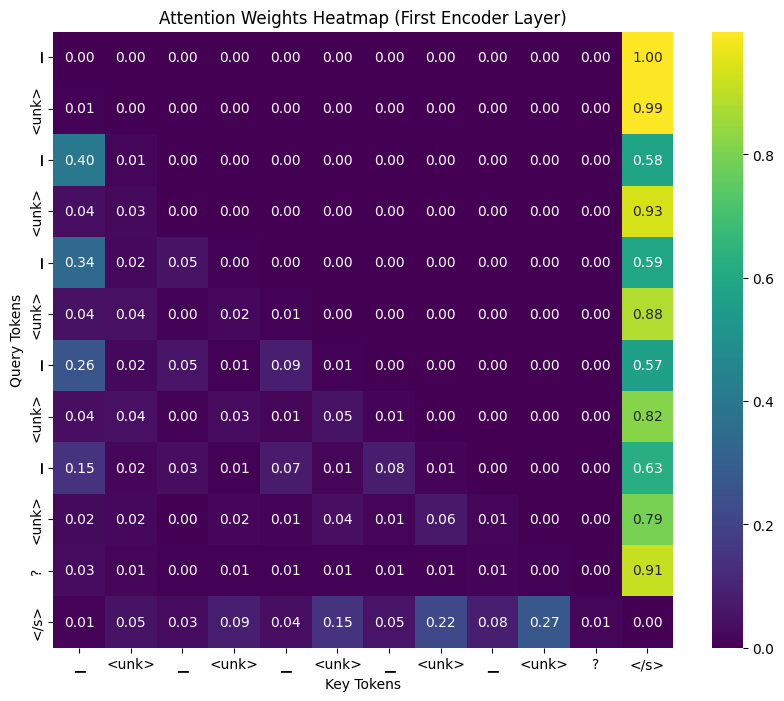

In [ ]:
first_layer_attention = outputs.encoder_attentions[11]  # Get the first layer's attention scores
# Convert to numpy and squeeze to get shape (num_heads, seq_length, seq_length)
attention_weights = first_layer_attention.squeeze().cpu().numpy()

# Plot the attention weights
plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights[11], cmap='viridis', annot=True, fmt='.2f',
            xticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy()),
            yticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy()))
plt.title("Attention Weights Heatmap (First Encoder Layer)")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()

In [ ]:
tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())

In [ ]:
! pip install -U langsmith
! pip install langchain-community

In [ ]:
! pip install optimum
! pip install auto-gptq

In [ ]:
! export LANGCHAIN_TRACING_V2=true
! export LANGCHAIN_API_KEY="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"

In [ ]:
! huggingface-cli login

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
# model_name_or_path = "google/flan-t5-base"
# model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
#                                              device_map="auto",
#                                              trust_remote_code=False,
#                                              revision="main")


In [ ]:
from langsmith import Client
client = Client()

In [ ]:
! pip install python-dotenv
from dotenv import find_dotenv, load_dotenv
import os
load_dotenv(find_dotenv())
os.environ["LANGCHAIN_API_KEY"] =" 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"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

LANGCHAIN_API_KEY= " 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"
LANGCHAIN_TRACING_V2='true'
LANGCHAIN_ENDPOINT='https://api.smith.langchain.com'

! export LANGCHAIN_TRACING_V2=true
! export LANGCHAIN_API_KEY=lkey
! export LANGCHAIN_ENDPOINT=https://api.smith.langchain.

In [ ]:
! pip install datasets

# Evaluating Model

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline
from datasets import load_dataset
llm = pipeline("text-generation", model=model, tokenizer=tokenizer)
dataset = load_dataset("xquad", "xquad.hi")


In [ ]:
from langsmith import evaluate

def evaluate_text_generation(model, dataset):
    generated_texts = []
    expected_texts = []

    for example in dataset["validation"]:
        prompt = example["question"]  # Use a question as a prompt
        expected_answer = example["answers"]["text"][0]  # Correct answer

        # Generate text (answer to the question)
        generated_text = model(prompt, max_length=100, num_return_sequences=1)[0]["generated_text"]

        # Collect generated and expected texts
        generated_texts.append(generated_text)
        expected_texts.append(expected_answer)

        break

    # Return results for LangSmith tracking
    return {"generated_texts": generated_texts, "expected_texts": expected_texts}

In [ ]:
dataset['validation'][1]

In [ ]:
evaluate_text_generation(llm, dataset)

# Question-Answering

In [ ]:
from transformers import T5ForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
model = T5ForQuestionAnswering.from_pretrained("google/flan-t5-base")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

In [ ]:
qa_llm = pipeline("question-answering", model=model, tokenizer=tokenizer)

In [ ]:
import tqdm

In [ ]:
def evaluate_qa_model(llm, dataset):
    generated_texts = []
    expected_texts = []

    for example in tqdm.tqdm(dataset["validation"]):
        # Ensure that `question` and `context` are provided
        question = example.get("question")
        context = example.get("context")
        if question is None or context is None:
            raise ValueError("Each example in the dataset must contain 'question' and 'context' fields.")

        expected_answer = example["answers"]["text"][0]

        # Generate the answer
        result = llm({"question": question, "context": context})

        # Retrieve the generated answer directly
        generated_text = result.get("answer")  # Use .get() to avoid KeyErrors

        if generated_text is None:
            raise KeyError("The result from the pipeline did not contain an 'answer' key.")

        # Collect generated and expected texts
        generated_texts.append(generated_text)
        expected_texts.append(expected_answer)
        break
    # Return results for LangSmith tracking
    return {"generated_texts": generated_texts, "expected_texts": expected_texts}



In [ ]:
dataset["validation"][0]

In [ ]:
evaluate_qa_model(qa_llm, dataset)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset

# Load dataset and model
dataset = load_dataset("xquad", "xquad.hi")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")

# Prepare inputs
examples = dataset["validation"]
inputs = [f"question: {example['question']} context: {example['context']}" for example in examples]

# Tokenize inputs
tokenized_inputs = tokenizer(inputs, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Generate outputs
outputs = model.generate(
    input_ids=tokenized_inputs["input_ids"],
    attention_mask=tokenized_inputs["attention_mask"],
    max_length=100,
    num_return_sequences=1,
    num_beams=5,
)

# Decode and print outputs
decoded_outputs = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
generated_texts = []
expected_texts = []
for example in dataset["validation"]:
    prompt = example["question"]  # Use a question as a prompt
    expected_answer = example["answers"]["text"][0]  # Correct answer

    # Generate text (answer to the question)
    generated_text = model(prompt, max_length=100, num_return_sequences=1)[0]["generated_text"]

    # Collect generated and expected texts
    generated_texts.append(generated_text)
    expected_texts.append(expected_answer)

    break
   # Return results for LangSmith tracking
print( "generated_texts"+ generated_texts+"expected_texts"+ expected_texts)
